# Проект: классификация

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
import optuna
from sklearn.model_selection import cross_val_score

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [38]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [39]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [40]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [41]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace('[$ ,]', '')
df['balance'] = df['balance'].astype('float')
df['balance'] = df['balance'].apply(lambda x: x/100)
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [42]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [43]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код   
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
mask = (df['education'] == df['education'].mode()[0]) & (df['job'] == df['job'].mode()[0])
round(df[mask]['balance'].mean(), 3)

1598.883

### Задание 6

In [44]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    """
    Очистка методом межквартильного размаха (методом Тьюки)
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

_, df, low, up = outliers_iqr_mod(df, 'balance')

print('Нижняя граница выбросов баланса: ', low)
print('Верхняя граница выбросов баланса: ', up)
df.shape

Нижняя граница выбросов баланса:  -2241.0
Верхняя граница выбросов баланса:  4063.0


(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64


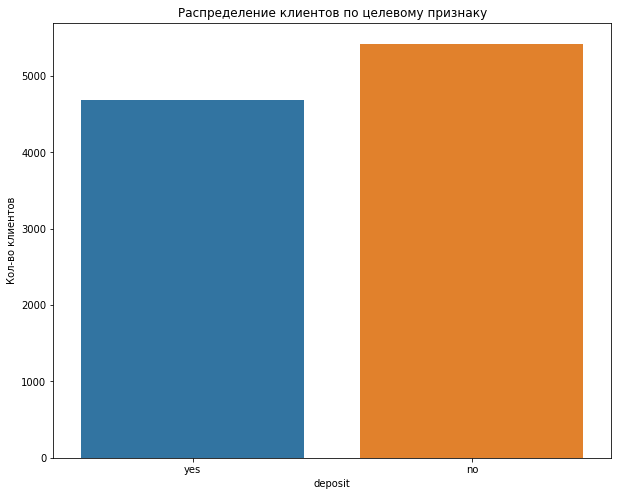

In [45]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
print(df['deposit'].value_counts())
sns.countplot(x='deposit', data=df).set(
    title='Распределение клиентов по целевому признаку',
    ylabel='Кол-во клиентов');

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


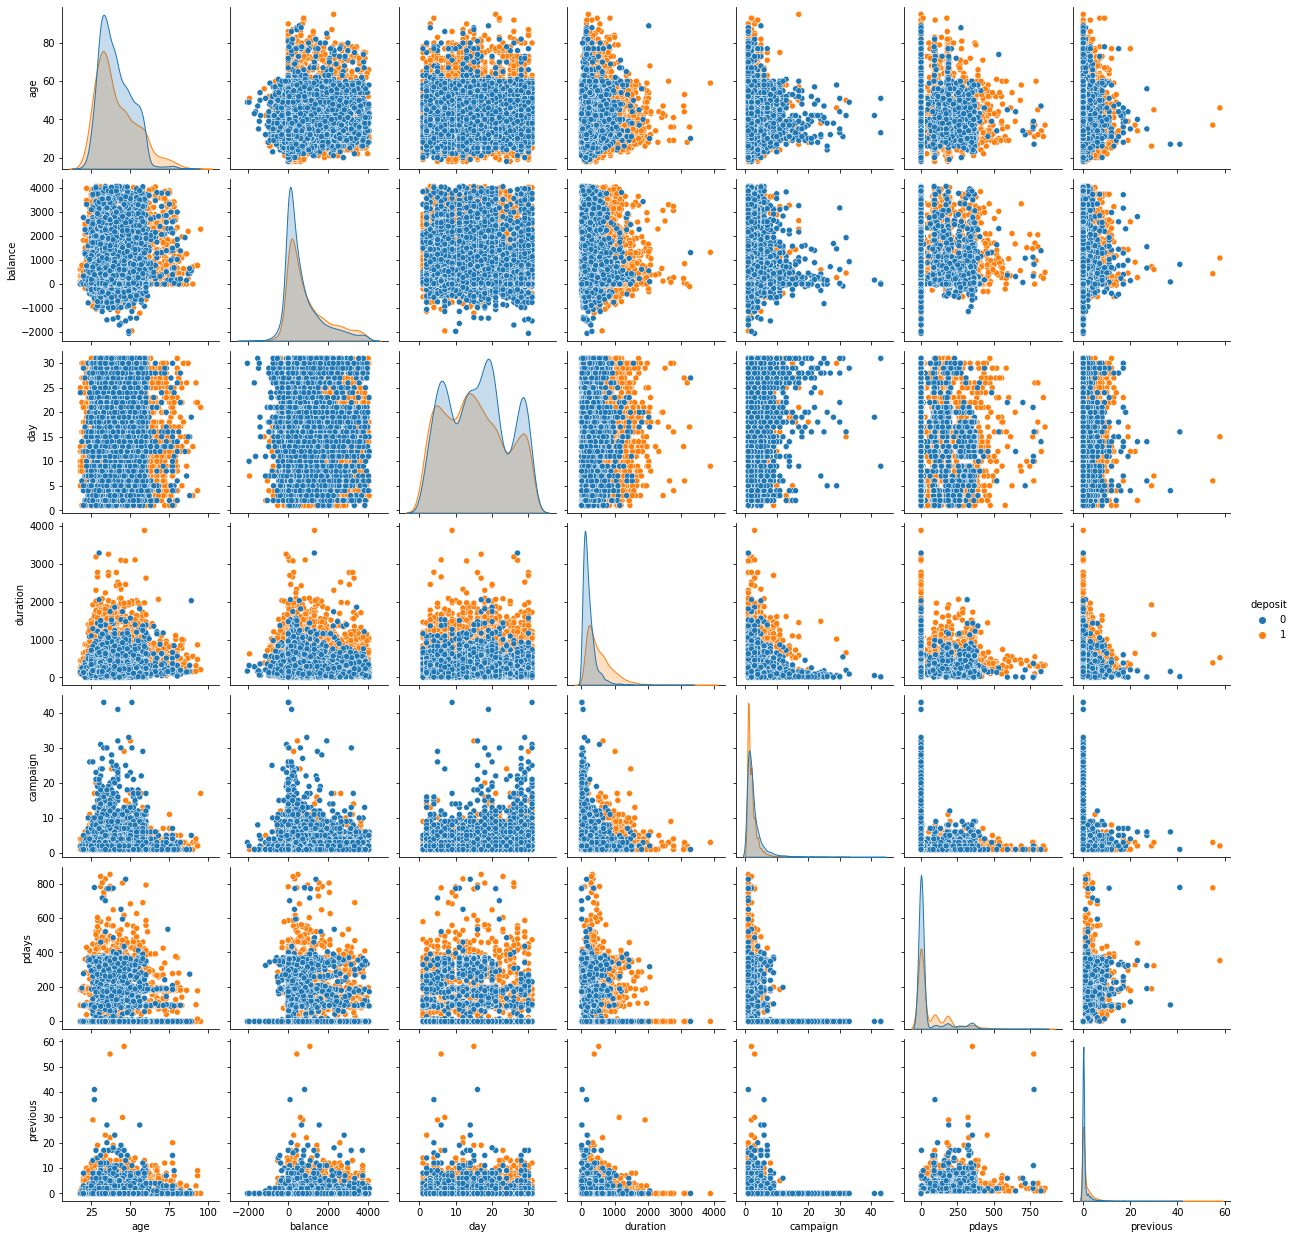

In [46]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
display(df.describe())
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)

sns.pairplot(df, hue='deposit')

### Задания 4 и 5

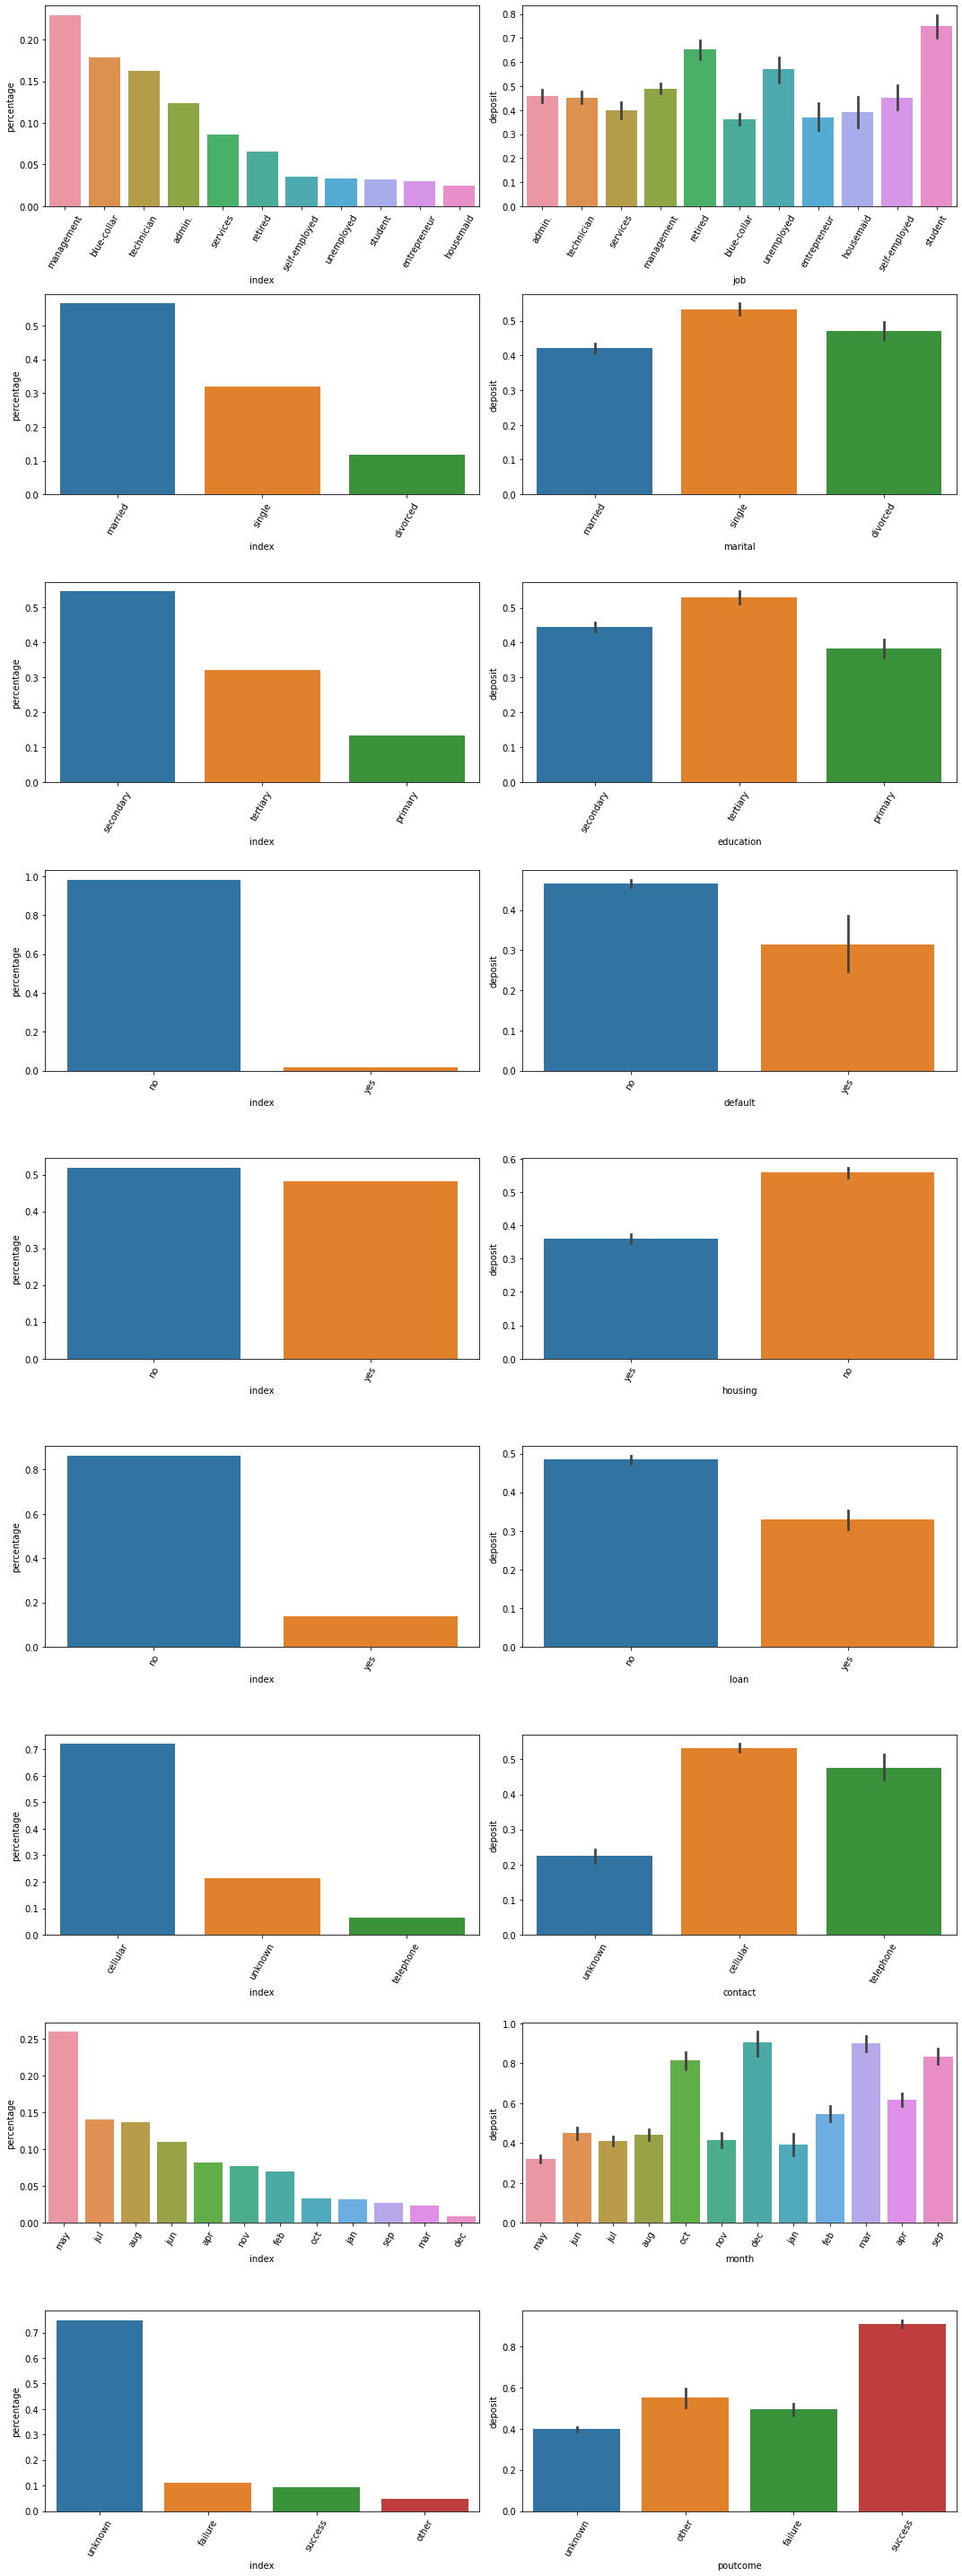

In [47]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
n = len(cat_features) #число категориальных признаков

fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей открывших депозит
    mean_barplot = sns.barplot(data=df, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков


### Задание 6

In [48]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df.groupby(['poutcome']).agg('mean')['deposit'].sort_values(ascending=False)

poutcome
success    0.911111
other      0.550936
failure    0.493237
unknown    0.397358
Name: deposit, dtype: float64

### Задание 7

In [49]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df.groupby(['month']).agg('mean')['deposit'].sort_values()

month
may    0.321360
jan    0.391850
jul    0.410437
nov    0.415385
aug    0.440433
jun    0.451087
feb    0.544429
apr    0.618072
oct    0.814925
sep    0.834532
mar    0.898734
dec    0.903226
Name: deposit, dtype: float64

### Задание 8

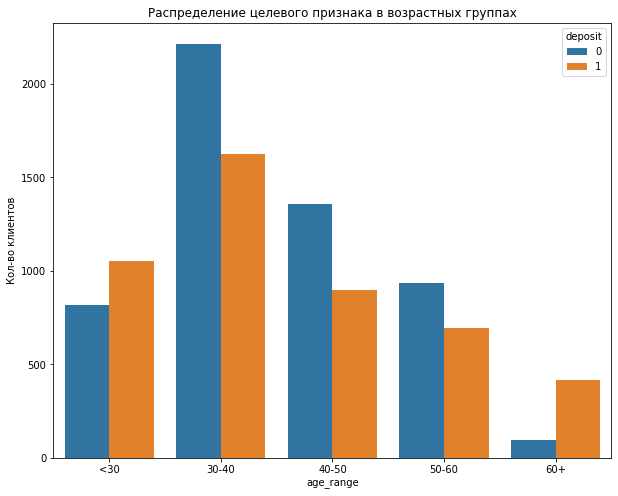

In [50]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
"""
def range_age(x):
    if x < 30: return '<30'
    if 30<= x < 40: return '30-40'
    if 40<= x < 50: return '40-50'
    if 50<= x < 60: return '50-60'
    if x >= 60: return '60+'
""" 
df['age_range'] = pd.cut(df.age, [0, 30, 40, 50, 60, 999], labels=['<30','30-40', '40-50', '50-60', '60+'])

sns.countplot(x='age_range', data=df, hue='deposit').set(
    title='Распределение целевого признака в возрастных группах',
    ylabel='Кол-во клиентов');

### Задания 9 и 10

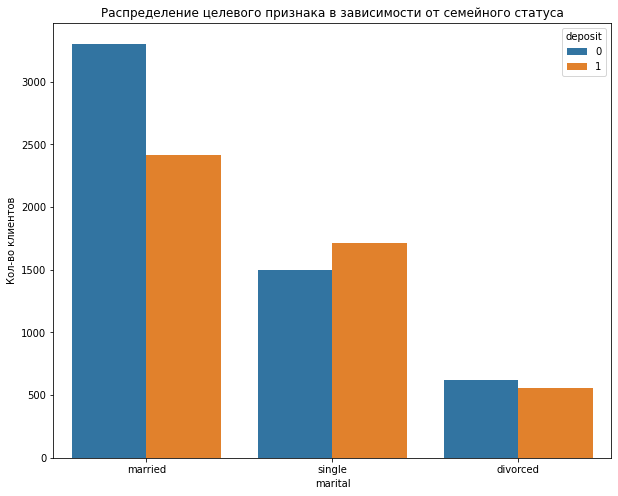

In [51]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(x='marital', data=df, hue='deposit').set(
    title='Распределение целевого признака в зависимости от семейного статуса',
    ylabel='Кол-во клиентов');

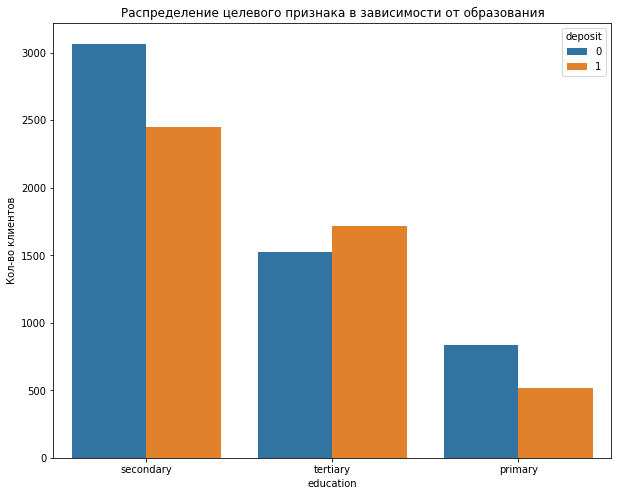

In [52]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(x='education', data=df, hue='deposit').set(
    title='Распределение целевого признака в зависимости от образования',
    ylabel='Кол-во клиентов');

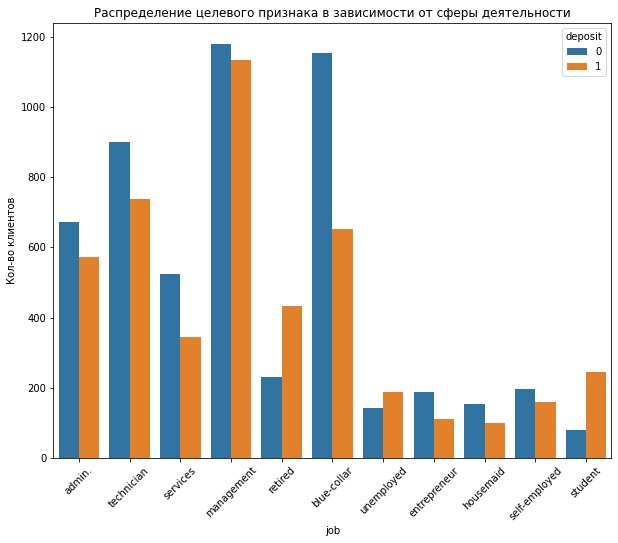

In [53]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(x='job', data=df, hue='deposit').set(
    title='Распределение целевого признака в зависимости от сферы деятельности',
    ylabel='Кол-во клиентов')
plt.xticks(rotation=45);

### Задание 11

[Text(0.5, 1.0, 'Клиенты открывшие депозит')]

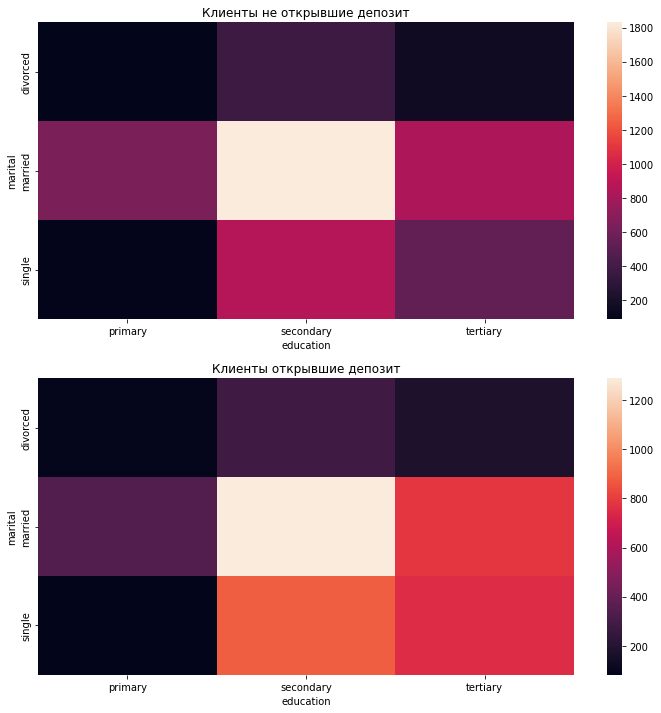

In [54]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_0 = df[df['deposit'] == 0] 
df_1 = df[df['deposit'] == 1] 
pivot_0 = pd.pivot_table(df_0,
                       index='marital',
                       columns='education',
                       values='deposit',
                       aggfunc='count') 
pivot_1 = pd.pivot_table(df_1,
                       index='marital',
                       columns='education',
                       values='deposit',
                       aggfunc='count') 

fig, axes = plt.subplots(2, 1, figsize=(12, 12))
sns.heatmap(pivot_0, ax=axes[0]).set(title='Клиенты не открывшие депозит')
sns.heatmap(pivot_1, ax=axes[1]).set(title='Клиенты открывшие депозит')


## Часть 3: преобразование данных

### Задание 1

In [55]:
# преобразуйте уровни образования
encoder = LabelEncoder()
df['education'] = encoder.fit_transform(df['education'])
print(df['education'].sum())

df['age_range'] = encoder.fit_transform(df['age_range'])

11995


### Задания 2 и 3

In [56]:
# преобразуйте бинарные переменные в представление из нулей и единиц
def bin_encoder(data, features):
    for feature in features:
        df[feature] = df[feature].apply(lambda x: 1 if x == 'yes' else 0)
        
bin_encoder(df, ['default', 'housing', 'loan'])

mean_sum = 0
for col in ['default', 'housing', 'loan']:
    mean_sum = mean_sum + df[col].mean()

mean_sum

0.6354280059376547

### Задание 4

In [57]:
# создайте дамми-переменные
col_list = ['job', 'marital', 'contact', 'month', 'poutcome']
dummies = pd.get_dummies(df[col_list], drop_first=False)
df = pd.concat([df, dummies], axis=1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1


### Задания 5 и 6

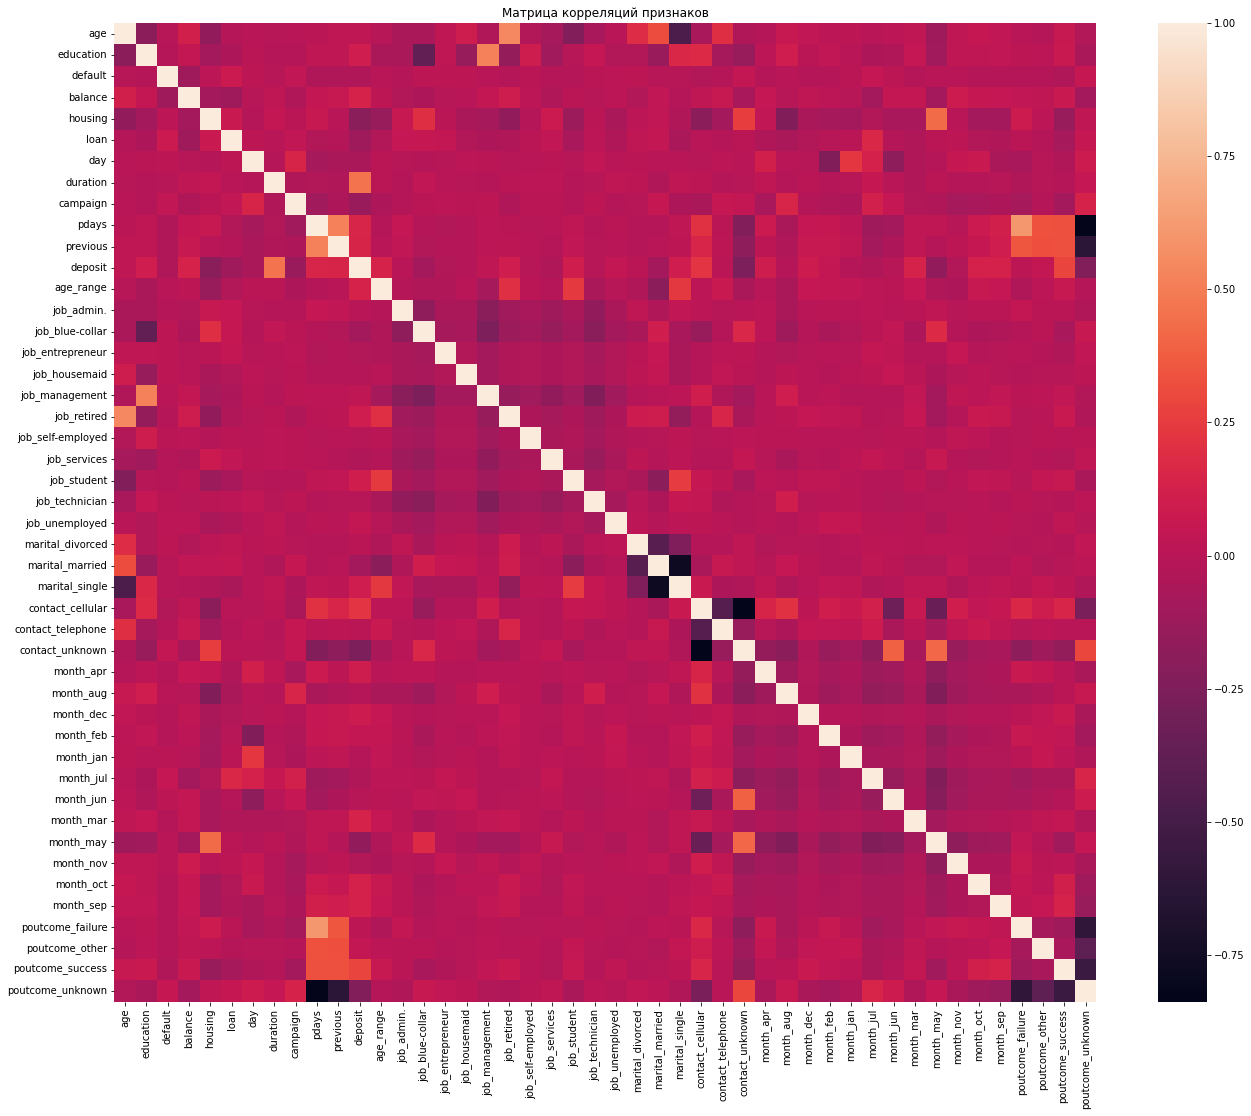

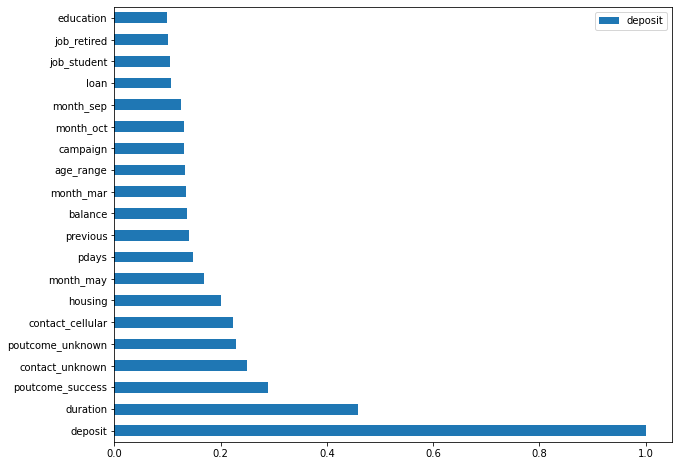

In [58]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(22,18))
ax = sns.heatmap(df.corr())
ax.set_title('Матрица корреляций признаков');
plt.rcParams['figure.figsize'] = (10,8)
corr_data = pd.DataFrame(abs(df.corr()['deposit']))
corr_data.nlargest(20, columns='deposit').plot(kind='barh');


### Задания 7 и 8

In [59]:
X = df.drop(['deposit', 'job', 'marital', 'contact', 'month', 'poutcome'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

In [60]:
# рассчитайте необходимые показатели
print('Размер тестовой выборки: ', X_test.shape)
print('Среднее значение целевой переменной на тестовой выборке: ', y_test.mean())

Размер тестовой выборки:  (3335, 45)
Среднее значение целевой переменной на тестовой выборке:  0.46326836581709147


### Задание 9

In [61]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
skb = SelectKBest(k=15)
skb.fit_transform(X_train, y_train)
top_15 = skb.get_feature_names_out()
print(top_15)

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_range'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [62]:
# нормализуйте данные с помощью minmaxsxaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[top_15])
X_test_scaled = scaler.transform(X_test[top_15])
print(X_test_scaled[:, 0].mean())

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [63]:
#!pip install scikit-learn==1.0.1

In [64]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [65]:
# обучите решающие деревья, настройте максимальную глубину
dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dtc.fit(X_train_scaled, y_train)
y_pred_train = dtc.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_pred_train))
y_pred_test = dtc.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



### Задание 5

In [66]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}
gs = GridSearchCV(param_grid=param_grid,
                  estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
                  cv=3, 
                  n_jobs = -1)

gs.fit(X_train_scaled, y_train)

dtc_best = tree.DecisionTreeClassifier(criterion='entropy',
                                       max_depth=gs.best_params_['max_depth'],
                                       min_samples_split=gs.best_params_['min_samples_split'],
                                       random_state=42)

dtc_best.fit(X_train_scaled, y_train)
y_pred_test = dtc_best.predict(X_test_scaled)
print(gs.best_params_)
print(metrics.classification_report(y_test, y_pred_test))

{'max_depth': 7, 'min_samples_split': 7}
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.82      0.81      0.81      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [67]:
# обучите на ваших данных случайный лес
rfc = ensemble.RandomForestClassifier(n_estimators = 100,
                                      criterion = 'gini',
                                      min_samples_leaf = 5,
                                      max_depth = 10,
                                      random_state = 42)
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [68]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом


gbc = GradientBoostingClassifier(learning_rate = 0.05,
                         n_estimators = 300,
                         min_samples_leaf = 5,
                         max_depth = 5,
                         random_state = 42)

gbc.fit(X_train_scaled, y_train)
y_pred = gbc.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [69]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [('lr', linear_model.LogisticRegression(solver='sag',
                                                     random_state=42,
                                                     max_iter=1000)),
              ('dtc',  tree.DecisionTreeClassifier(criterion='entropy',
                                       max_depth=6,
                                       min_samples_split=7,
                                       random_state=42)),
              ('gbc', GradientBoostingClassifier(learning_rate = 0.05,
                         n_estimators = 300,
                         min_samples_leaf = 5,
                         max_depth = 5,
                         random_state = 42))]
    
sc = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
# Обучаем модель
sc.fit(X_train_scaled, y_train)
y_pred = sc.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [70]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
gbc.feature_importances_

array([0.05795212, 0.04772538, 0.50710587, 0.01477693, 0.05507696,
       0.00844892, 0.03990225, 0.00362013, 0.07258213, 0.02781861,
       0.01521407, 0.01988016, 0.01352999, 0.11495825, 0.00140822])

### Задания 6,7,8

In [71]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
def optuna_rfc(trial_optuna_rfc):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial_optuna_rfc.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial_optuna_rfc.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial_optuna_rfc.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring="f1", n_jobs=-1).mean()

  return score

# cоздаем объект исследования
study_rfc = optuna.create_study(study_name='RandomForestClassifier', direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rfc.optimize(optuna_rfc, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rfc.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rfc.best_value))\
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study_rfc.best_params,random_state=42)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))


[I 2023-04-15 16:40:20,134] A new study created in memory with name: RandomForestClassifier
[I 2023-04-15 16:40:21,111] Trial 0 finished with value: 0.8219899713518961 and parameters: {'n_estimators': 123, 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8219899713518961.
[I 2023-04-15 16:40:21,992] Trial 1 finished with value: 0.8240945031800407 and parameters: {'n_estimators': 117, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8240945031800407.
[I 2023-04-15 16:40:23,288] Trial 2 finished with value: 0.8187959938579877 and parameters: {'n_estimators': 142, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8240945031800407.
[I 2023-04-15 16:40:24,569] Trial 3 finished with value: 0.8231916553839665 and parameters: {'n_estimators': 157, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8240945031800407.
[I 2023-04-15 16:40:25,640] Trial 4 finished with value: 0.8237166551718694 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 117, 'max_depth': 12, 'min_samples_leaf': 4}
f1_score на обучающем наборе: 0.82
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1790
           1       0.81      0.86      0.84      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.85      0.84      0.84      3335



In [72]:
#!pip freeze > requirements.txt